In [1]:
## importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import nn

# setup the device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

* Our dataset is subset of Food101 dataset.
    * Food101 starts with 101 different classes of food and 1000 images per class (750 training and 250 testing)
    * Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

#### Downloading data directly from github repo

In [2]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

# if image folder doesn't exist, download it and preapare it
if image_path.is_dir():
    print(f"{image_path} directory already exists....skipping downloading)")
else:
    print(f"{image_path} doesn't exist, creating one......")
    image_path.mkdir(parents=True, exist_ok=True)        

data\pizza_steak_sushi directory already exists....skipping downloading)


In [3]:
## download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the pizza, steak, sushi data..... ")
    f.write(request.content)

## unzip the downloaded zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping ..........")
    zip_ref.extractall(image_path)

Unzipping ..........


## Data preparation and Data exploration

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")      

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
## setup the train and test paths so that we can look at the train and test images
train_dir = image_path/ "train"
test_dir = image_path/"test"

## Visualizing images
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get a image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

data\pizza_steak_sushi\test\steak\502076.jpg
steak
<class 'PIL.JpegImagePlugin.JpegImageFile'>
Random image path: data\pizza_steak_sushi\test\steak\502076.jpg
Image class: steak
Image height: 512
Image width: 512


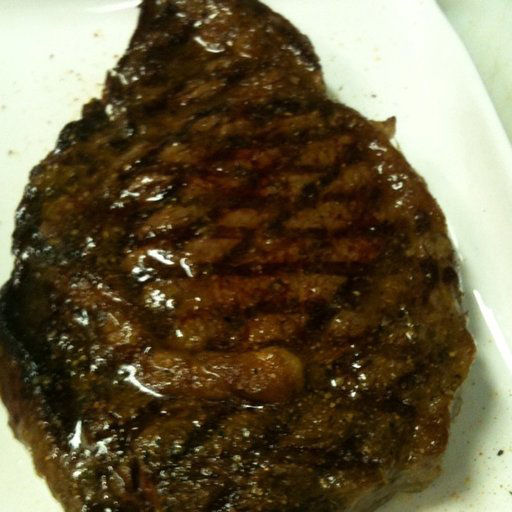

In [7]:
import random
from PIL import Image
# random.seed(42)

## get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

## get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

## Open image using PIL
img = Image.open(random_image_path)
print(type(img))

## print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

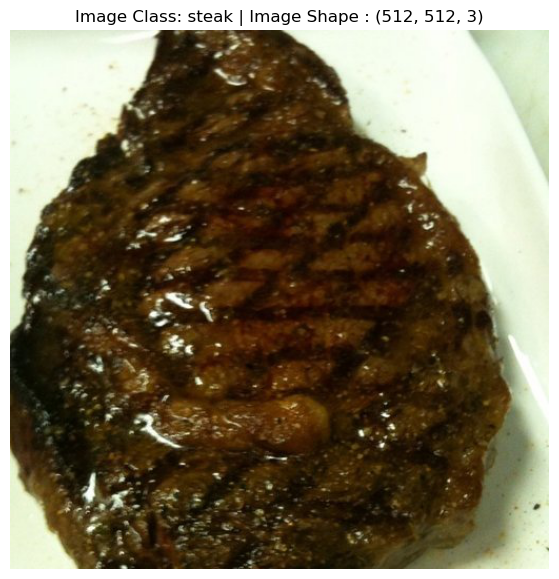

In [8]:
## Try to visualize the images using matplotlib

img_as_array = np.asanyarray(img)

# plot the image using matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape : {img_as_array.shape}")
plt.axis(False)

## Tranforming Data

**Before we can use out image data with PyTorch:**
1. Turn your target data into tensors
2. Turn it into a `torch.utlis.data.Dataset` and subsequently `torch.utlis.data.DataLoader`. Call these `datasets` and `dataloaders`

In [9]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Transforming data with `torchvision.transforms`
* **from .jpg to Tensor**

In [10]:
"""
Transforms.ToTensor()--> will take images as input in PIL format and  numpy.ndarray, 
`documentation`: https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html 
"""
# Write a tranform for image
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),        # resize the images to 64x64 so that standard model can be used directly
                                     transforms.RandomHorizontalFlip(p=0.5), # flip the images randomly on the horizontal
                                     transforms.ToTensor()])                 # turn the image into torch.Tensor

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Select random images from a path of images and transforms them,
    then plots the original vs transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    
    # sampled through random_image_paths
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False) 
            
            # Transform and plot transformed verison of the image
            transformed_image = transform(f).permute(1,2,0) # transformed image shape [3,64,64] --> channel comes first
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            # print the supertitle
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
        

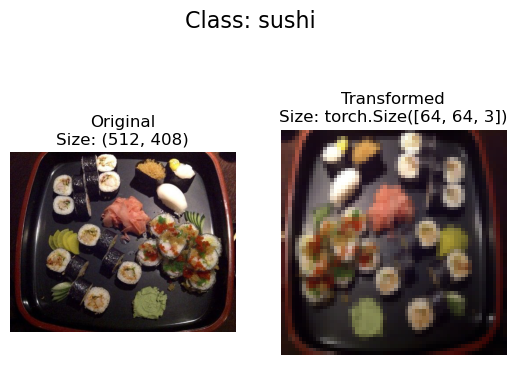

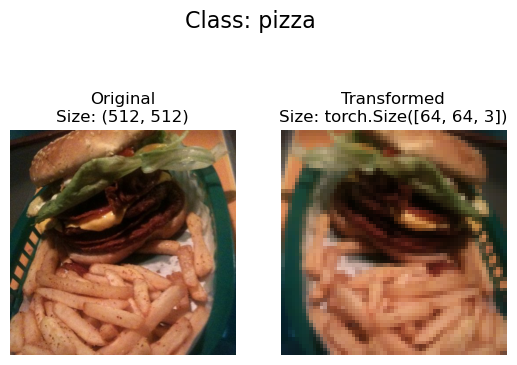

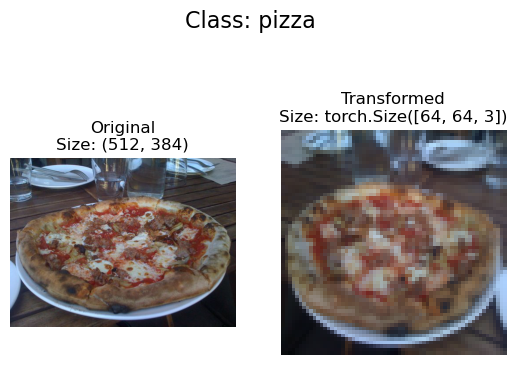

In [13]:
plot_transformed_images(image_paths=image_path_list, 
                        transform=data_transform,
                        n=3,
                        seed=42)

## Option 1: Loading Image Data using `ImageFolder`
**`documentation:`**https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html

In [14]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,# transfrom for input data
                                  target_transform=None)   # transform for a label
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
## get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
## get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
## check the len of datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
## get single image and label from the train dataset
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatypes: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

## Turn loaded images into `DataLoaders`:
* Dataloaders helps us turn our `Dataset's` into iterables and we can customise the `batch_size` so our model can see batch_size images at a time

In [19]:
# turn the test and train datasets into Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle = True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ddc06e3910>,
 <torch.utils.data.dataloader.DataLoader at 0x1ddc06e21d0>)

In [20]:
## length of dataloaders
len(train_dataloader), len(test_dataloader)

(8, 3)

In [21]:
# get the image sample form Dataloaders
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")

Image shape: torch.Size([32, 3, 64, 64])
